<a href="https://colab.research.google.com/github/Xenonimous/Garbage/blob/master/Inception_Resnet_Ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking Tensorflow version (Optional)


Before running the shell please make sure that you have changed Runtime 
Type into GPU



In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

Importing Libraries

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import random

from google.colab import files

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.6.0


Installing kaggle to colab

In [3]:
! pip install -q kaggle

Importing Files to colab with kaggle api

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rianm2482358","key":"041b05d8f835f38c3c492f0da9922584"}'}

Making kaggle directory

In [5]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

Downloading Garbage Classification dataset from Kaggle

In [6]:
! kaggle datasets download -d asdasdasasdas/garbage-classification

 78% 64.0M/82.0M [00:00<00:00, 103MB/s] 
100% 82.0M/82.0M [00:00<00:00, 140MB/s]


Unzipping the dataset

In [7]:
! unzip garbage-classification.zip -d temp
! mv temp/Garbage\ classification/Garbage\ classification .
! rm -r temp
! mv Garbage\ classification datasets



Streaming output truncated to the last 5000 lines.
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: temp/Ga

Splitting Training, Testing, and Validation dataset

In [8]:
#Download and Install split_folders package
! pip install split-folders

In [9]:
#Split datasets into new folder
import splitfolders
splitfolders.ratio('/content/datasets/', output="datasplit", seed=1337, ratio=(0.7, 0.15,0.15))

Copying files: 2527 files [00:00, 4671.19 files/s]


Generating data for training, testing, and validating

In [10]:
train_dir = '../content/datasplit/train/'
test_dir = '../content/datasplit/test/'
val_dir = '../content/datasplit/val/'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )

datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (299, 299)
    )

test_generator = datagen.flow_from_directory(
    test_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (299, 299)
    )

validation_generator = datagen.flow_from_directory(
    val_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (299, 299)
    )

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


Transfer Learning : Inception V3

In [11]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping

# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('accuracy')>0.95 or logs.get('val_accuracy')>0.90):
#             print("\nCanceling Training: Accuracy Reached 95% or Validation Accuracy Reached 90%")
#             self.model.stop_training = True

# callbacks=myCallback()

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'check_point_model.hdf5',
    verbose=1,
    save_best_only=True)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1)

base_model = tf.keras.applications.InceptionResNetV2(
    input_shape = (299, 299, 3),
    include_top = False,
    weights = 'imagenet'
)

base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
predictions = tf.keras.layers.Dense(6, activation="softmax")(x)

model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=predictions
    )

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 32,
    epochs = 100,
    verbose = 1,
    validation_steps = 5,
    callbacks=[model_checkpoint,early_stop]
    )

219070464/219055592 [==============================] - 2s 0us/step
Epoch 1/100
32/32 [==============================] - 83s 1s/step - loss: 0.8450 - accuracy: 0.6895 - val_loss: 0.4381 - val_accuracy: 0.8375

Epoch 00001: val_loss improved from inf to 0.43807, saving model to check_point_model.hdf5
Epoch 2/100
32/32 [==============================] - 37s 1s/step - loss: 0.5794 - accuracy: 0.7866 - val_loss: 0.5646 - val_accuracy: 0.8125

Epoch 00002: val_loss did not improve from 0.43807
Epoch 3/100
32/32 [==============================] - 36s 1s/step - loss: 0.5993 - accuracy: 0.7796 - val_loss: 0.4681 - val_accuracy: 0.8188

Epoch 00003: val_loss did not improve from 0.43807
Epoch 4/100
32/32 [==============================] - 35s 1s/step - loss: 0.5428 - accuracy: 0.7956 - val_loss: 0.5683 - val_accuracy: 0.7875

Epoch 00004: val_loss did not improve from 0.43807
Epoch 5/100
32/32 [==============================] - 35s 1s/step - loss: 0.5526 - accuracy: 0.7926 - val_loss: 0.5656 - v

Save model

In [12]:
model.save('mobilenetv2_model.h5')
# tf.saved_model.save(model,'../content/')

Evaluate the model

In [13]:
model.evaluate(test_generator, steps = 10)

10/10 [==============================] - 8s 751ms/step - loss: 0.3956 - accuracy: 0.8656


[0.3956414759159088, 0.8656250238418579]

Model Summary

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Accuracy and Loss Plot

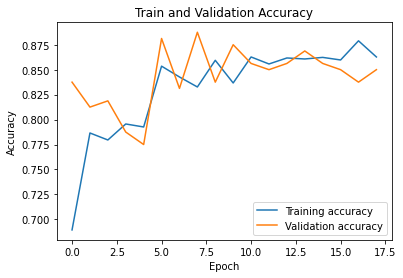

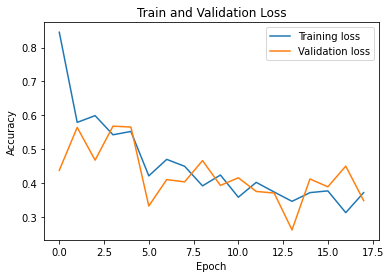

In [15]:
#Accuracy plot
plt.title("Train and Validation Accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.legend(["Training accuracy","Validation accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

#Loss plot
plt.title("Train and Validation Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss","Validation loss"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

Test the model

Saving metal.jpg to metal.jpg


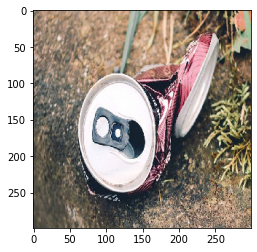

Cardboard: 0.00%
Glass: 0.24%
Metal: 99.74%
Paper: 0.00%
Plastic: 0.01%
Trash: 0.00%


In [20]:
from keras_preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

uploaded = files.upload()
labels = train_generator.class_indices.keys()

for name in uploaded.keys():
    path = name
    img = image.load_img(path, target_size=(299, 299))
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    images = np.vstack([x])
    probability = model.predict(images)[0]
    for (label, p) in zip(labels, probability):
        print("{}: {:.2f}%".format(label.capitalize(), p * 100))


Checking Model Size (Optional)

In [21]:
print (str(os.path.getsize('mobilenetv2_model.h5')/1024**2) + ' MB')

218.32677459716797 MB


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenetv2_model.tflite', 'wb') as f:
  f.write(tflite_model)

# saved_model_dir = '../content/'
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# tflite_model = converter.convert()

# with open('saved_model.tflite', 'wb') as f:
#   f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmplolu22yh/assets


In [23]:
print (str(os.path.getsize('mobilenetv2_model.tflite')/1024**2) + ' MB')

210.1916847229004 MB


In [24]:
new_model = tf.keras.models.load_model('mobilenetv2_model.h5')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________